# Titanic Machine Learning
## 1. Problem definition:
- Titanic  is based on the sinking of the ‘Unsinkable’ ship Titanic in the early 1912. The dataset 'train' provides information about multiple passengers, including their ages, sexes, sibling counts, embarkment points and whether or not they survived the disaster. Based on these features, I have tried to predict if an arbitrary passenger on Titanic would survive the sinking

### Approach
- 1.1 Split train and test data set for validation 
- 2. Feature engineer the variables to be fit for the model for both the training and test data
- 3. Train a LogReg model 
- 3.1 Calculate test score and cross validate
- 4. Train and test Random Forest model
- 4.1 Calculate test score and cross validate
- 5. Optimize Hyperparameters

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from scipy import stats

#from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [2]:
#import data sets
train = pd.read_csv('/Users/sabrinafruhauf/Desktop/05_SpicedCourse/Week_02_machine_learning/train.csv')
kaggle = pd.read_csv('/Users/sabrinafruhauf/Desktop/05_SpicedCourse/Week_02_machine_learning/test.csv')

## 1.1 Split data set in test and train

In [3]:
x = train[['PassengerId', 'Pclass','Sex','Age','SibSp','Parch','Fare','Cabin','Embarked']]
y = train['Survived']

In [4]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.2, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((712, 9), (179, 9), (712,), (179,))

In [5]:
df_train = pd.concat([ytrain, xtrain], axis=1)
df_test = pd.concat([ytest, xtest], axis=1)

df_train.shape, df_test.shape

((712, 10), (179, 10))

## 2. Feature engineering of the dataset

### Check for missing values in all data sets
- missing values age
- missing values in Cabin, Embarked and Fare

In [6]:
df_train.isnull().sum()

Survived         0
PassengerId      0
Pclass           0
Sex              0
Age            140
SibSp            0
Parch            0
Fare             0
Cabin          553
Embarked         2
dtype: int64

In [7]:
df_test.isnull().sum()

Survived         0
PassengerId      0
Pclass           0
Sex              0
Age             37
SibSp            0
Parch            0
Fare             0
Cabin          134
Embarked         0
dtype: int64

In [8]:
kaggle.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### Treating missing values in the data set
- Replace missing age values with mean of Pclass and Sex
- Replace missing Embarked port with Southhampton as most people embarked here and its only 2 missing rows

In [9]:
age = ['Age']

def fill_missing_values_age (df, fcol):
    means = df[fcol].fillna(df.groupby(['Pclass','Sex'])['Age'].transform('mean'))
    fcol2 = df[fcol].copy()
    fcol2[fcol2.isna()] = means
    df[fcol] = fcol2


for fcol in age:
    fill_missing_values_age(df_train, fcol)
    fill_missing_values_age(df_test, fcol)
    fill_missing_values_age(kaggle, fcol)

In [10]:
embark = ['Embarked']

def fill_missing_values_embark (df, fcol):
    fill = df[fcol].fillna('S')
    fcol2 = df[fcol].copy()
    fcol2[fcol2.isna()] = fill
    df[fcol] = fcol2


for fcol in embark:
    fill_missing_values_embark(df_train, fcol)
    fill_missing_values_embark(df_test, fcol)
    fill_missing_values_embark(kaggle, fcol)

In [11]:
fare = ['Fare']

def fill_missing_values_fare (df, fcol):
    median = df[fcol].fillna(df.Fare.median())
    fcol2 = df[fcol].copy()
    fcol2[fcol2.isna()] = median
    df[fcol] = fcol2


for fcol in fare:
    fill_missing_values_fare(df_train, fcol)
    fill_missing_values_fare(df_test, fcol)
    fill_missing_values_fare(kaggle, fcol)

In [12]:
df_train.isnull().sum(), df_test.isnull().sum(), kaggle.isnull().sum()

(Survived         0
 PassengerId      0
 Pclass           0
 Sex              0
 Age              0
 SibSp            0
 Parch            0
 Fare             0
 Cabin          553
 Embarked         0
 dtype: int64,
 Survived         0
 PassengerId      0
 Pclass           0
 Sex              0
 Age              0
 SibSp            0
 Parch            0
 Fare             0
 Cabin          134
 Embarked         0
 dtype: int64,
 PassengerId      0
 Pclass           0
 Name             0
 Sex              0
 Age              0
 SibSp            0
 Parch            0
 Ticket           0
 Fare             0
 Cabin          327
 Embarked         0
 dtype: int64)

Mapping string male and female to a binary value 0,1

In [13]:
mapping = {'male':0, 'female':1}
df_train = df_train.replace({'Sex':mapping})
df_test = df_test.replace({'Sex':mapping})
kaggle = kaggle.replace({'Sex':mapping})

Use one hot encoding to convert column 'Embarked' and attach at the end of the data frame

In [14]:
onehot_train = pd.get_dummies(df_train['Embarked'], prefix='Embarked_')
df_train2 = pd.concat([df_train, onehot_train], axis=1)
onehot_test = pd.get_dummies(df_test['Embarked'], prefix='Embarked_')
df_test2 = pd.concat([df_test, onehot_test], axis=1)
onehot_kaggle = pd.get_dummies(kaggle['Embarked'], prefix='Embarked_')
kaggle2 = pd.concat([kaggle, onehot_kaggle], axis=1)

Include 4 bins for column Age in the data set and append at the end

In [15]:
bins1 = pd.IntervalIndex.from_tuples([(0, 16), (16.01, 30), (30.01, 90)])
bins_train = pd.cut(df_train2['Age'], bins1)
bins_train = pd.get_dummies(bins_train, prefix='Age')
df_train3 = pd.concat([df_train2, bins_train], axis=1)
df_train3 = df_train3.rename(columns={1:'Pclass_1',2:'Pclass_2',3:'Pclass_3', 'Age_(0.0, 16.0]':'Age_0-16', 'Age_(16.01, 30.0]':'Age_16-30','Age_(30.01, 90.0]':'Age_30-90'})

bins_test = pd.cut(df_test2['Age'], bins1)
bins_test = pd.get_dummies(bins_test, prefix='Age')
df_test3 = pd.concat([df_test2, bins_test], axis=1)
df_test3 = df_test3.rename(columns={1:'Pclass_1',2:'Pclass_2',3:'Pclass_3', 'Age_(0.0, 16.0]':'Age_0-16', 'Age_(16.01, 30.0]':'Age_16-30','Age_(30.01, 90.0]':'Age_30-90'})

bins_kaggle = pd.cut(kaggle2['Age'], bins1)
bins_kaggle = pd.get_dummies(bins_kaggle, prefix='Age')
kaggle3 = pd.concat([kaggle2, bins_kaggle], axis=1)
kaggle3 = kaggle3.rename(columns={1:'Pclass_1',2:'Pclass_2',3:'Pclass_3', 'Age_(0.0, 16.0]':'Age_0-16', 'Age_(16.01, 30.0]':'Age_16-30','Age_(30.01, 90.0]':'Age_30-90'})


### Rechecking feature correlation to Survival rate
- Sex, Pclass, Fare, Embarked_C,Embarked_S,(I will add Embarked_Q), Parch and Age all have reasonable correlation to 'Survived'
- thus these features will be used to train the model

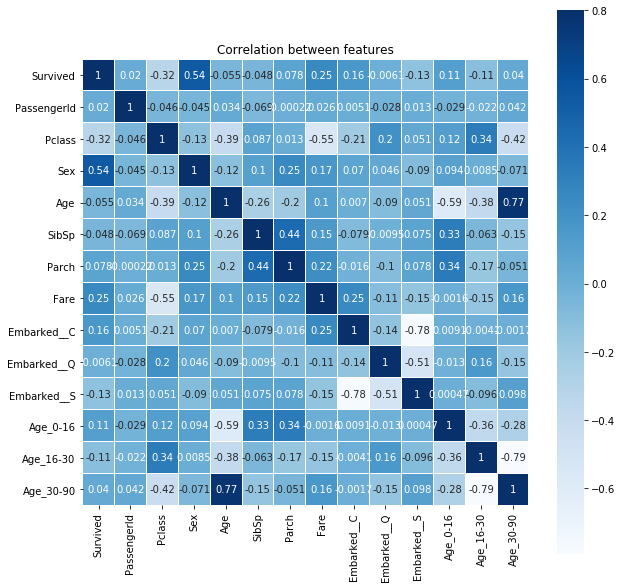

In [45]:
corr=df_train3.corr() #["Survived"]
plt.figure(figsize=(10, 10))
sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='Blues',linecolor="white")
plt.title('Correlation between features')
plt.savefig("feature_corr.png")

In [17]:
df_train3.corr()["Survived"].abs().sort_values(ascending=False)

Survived       1.000000
Sex            0.541750
Pclass         0.321750
Fare           0.246641
Embarked__C    0.159632
Embarked__S    0.134623
Age_0-16       0.114226
Age_16-30      0.111674
Parch          0.078311
Age            0.054586
SibSp          0.047602
Age_30-90      0.040343
PassengerId    0.019979
Embarked__Q    0.006097
Name: Survived, dtype: float64

## 3. Train a LogReg model

In [18]:
# define the variables for training and testing
x_train = df_train3[['Sex','Pclass','Fare','Embarked__C','Embarked__S','Embarked__Q','Parch','Age']]
y_train = df_train3['Survived'] 
x_test = df_test3[['Sex','Pclass','Fare','Embarked__C','Embarked__S','Embarked__Q','Parch','Age']]
y_test = df_test3['Survived']
x_kaggle = kaggle3[['Sex','Pclass','Fare','Embarked__C','Embarked__S','Embarked__Q','Parch','Age']]

In [19]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_kaggle.shape

((712, 8), (712,), (179, 8), (179,), (418, 8))

In [20]:
# fit the model
model_lg = LogisticRegression(max_iter=2000) #initialise model
model_lg.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
# show training and test score
print('training score: ',model_lg.score(x_train,y_train).round(3))
print('test score: ',model_lg.score(x_test,y_test).round(3)) #check the data and how good the model is

training score:  0.791
test score:  0.804


In [22]:
# predict y values
y_train_pred = model_lg.predict(x_train)
y_test_pred = model_lg.predict(x_test)
y_kaggle_pred = model_lg.predict(x_kaggle)

## 3.1 Calculate test score and cross validate

In [23]:
# Accuracy
accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)

(0.7907303370786517, 0.8044692737430168)

In [24]:
# Precision
precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)

(0.7389558232931727, 0.782608695652174)

In [25]:
# Recall
recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred)

(0.6865671641791045, 0.7297297297297297)

In [26]:
# F1
f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred)

(0.7117988394584139, 0.7552447552447553)

Text(0.5, 1.05, 'Confusion_matrix for Training Data')

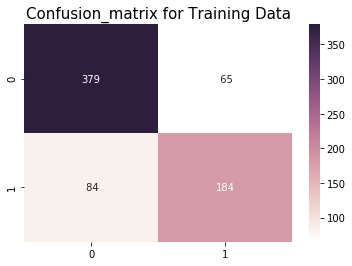

In [27]:
# confusion matrix training data
sns.heatmap(confusion_matrix(y_train,y_train_pred),annot=True,fmt='3.0f',cmap=sns.cubehelix_palette(light=1, as_cmap=True))
plt.title('Confusion_matrix for Training Data', y=1.05, size=15)

Text(0.5, 1.05, 'Confusion_matrix for Test Data')

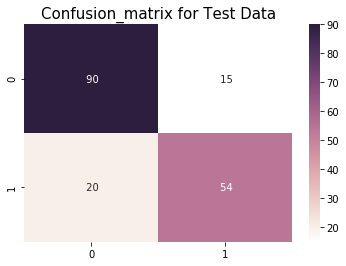

In [28]:
# confusion matrix test data
sns.heatmap(confusion_matrix(y_test,y_test_pred),annot=True,fmt='3.0f',cmap=sns.cubehelix_palette(light=1, as_cmap=True))
plt.title('Confusion_matrix for Test Data', y=1.05, size=15)

## 4. Train a Random Forest model

In [41]:
# train random forest model
model_rf = RandomForestClassifier(criterion='gini',  
                                  n_estimators=383, 
                                  min_samples_split=8, 
                                  min_samples_leaf=1,
                                  max_depth=5,
                                  max_features=6,
                                  oob_score=True,
                                  random_state=1,
                                  n_jobs=-1)
model_rf.fit(x_train,  np.ravel(y_train))

print('training score: ',model_rf.score(x_train,y_train).round(3))
print('test score: ',model_rf.score(x_test,y_test).round(3)) #check the data and how good the model is

training score:  0.858
test score:  0.81


In [42]:
# predict y values
y_train_pred_rf = model_rf.predict(x_train)
y_test_pred_rf = model_rf.predict(x_test)
y_kaggle_pred_rf = model_rf.predict(x_kaggle)

## 4.1 Calculate test score and cross validate

In [31]:
# Accuracy
accuracy_score(y_train, y_train_pred_rf), accuracy_score(y_test, y_test_pred)

(0.875, 0.8044692737430168)

In [32]:
# Precision
precision_score(y_train, y_train_pred_rf), precision_score(y_test, y_test_pred)

(0.92018779342723, 0.782608695652174)

In [33]:
# Recall
recall_score(y_train, y_train_pred_rf), recall_score(y_test, y_test_pred)

(0.7313432835820896, 0.7297297297297297)

In [34]:
# F1
f1_score(y_train, y_train_pred_rf), f1_score(y_test, y_test_pred)

(0.8149688149688149, 0.7552447552447553)

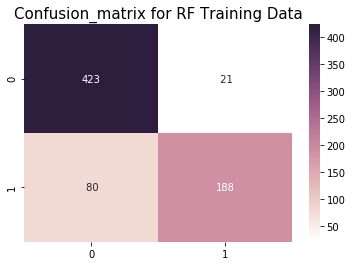

In [46]:
sns.heatmap(confusion_matrix(y_train,y_train_pred_rf),annot=True,fmt='3.0f',cmap=sns.cubehelix_palette(light=1, as_cmap=True))
plt.title('Confusion_matrix for RF Training Data', y=1.05, size=15)
plt.savefig("RF_confusion.png")

Text(0.5, 1.05, 'Confusion_matrix for RF Test Data')

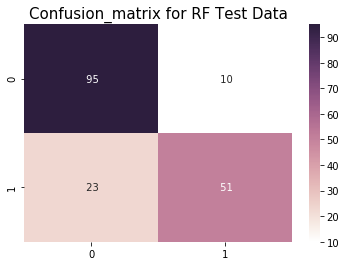

In [36]:
# confusion matrix test data
sns.heatmap(confusion_matrix(y_test,y_test_pred_rf),annot=True,fmt='3.0f',cmap=sns.cubehelix_palette(light=1, as_cmap=True))
plt.title('Confusion_matrix for RF Test Data', y=1.05, size=15)

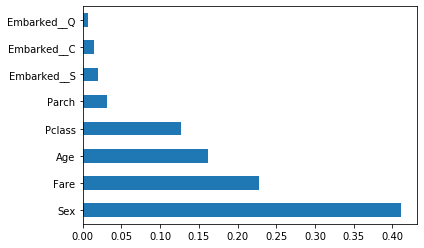

In [37]:
feat_importances = pd.Series(model_rf.feature_importances_, index=['Sex','Pclass','Fare','Embarked__C','Embarked__S','Embarked__Q','Parch','Age'])
feat_importances.nlargest(9).plot(kind='barh')

## 5. Hyperparameter optimization

In [38]:
# optimization of parameters in random forest model, due to large spread between train and test scores
# new parameter where already applied in above model to avoid lengthy code
param_distributions = {'n_estimators': list(range(20, 700)),
                       'min_samples_split':list(range(3,10)),
                       'min_samples_leaf': list(range(1,5)),
                       'max_depth': list(range(3, 15)),
                       'max_features':list(range(2, 8))}

In [39]:
randomizedcv = RandomizedSearchCV(model_rf, param_distributions=param_distributions)
randomizedcv.fit(x_train, y_train)
random_results = pd.DataFrame(randomizedcv.cv_results_)
display(random_results.sort_values('mean_test_score', ascending=False))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,0.767851,0.070192,0.107404,0.001865,383,8,1,6,5,"{'n_estimators': 383, 'min_samples_split': 8, ...",0.832168,0.846154,0.838028,0.802817,0.852113,0.834256,0.017131,1
3,0.400248,0.130160,0.105851,0.001784,145,3,1,2,9,"{'n_estimators': 145, 'min_samples_split': 3, ...",0.804196,0.832168,0.823944,0.830986,0.845070,0.827273,0.013402,2
1,0.344966,0.050091,0.106638,0.002293,188,7,3,4,7,"{'n_estimators': 188, 'min_samples_split': 7, ...",0.832168,0.832168,0.823944,0.795775,0.830986,0.823008,0.013957,3
0,0.418949,0.568612,0.105336,0.000788,47,8,4,5,10,"{'n_estimators': 47, 'min_samples_split': 8, '...",0.832168,0.839161,0.816901,0.795775,0.830986,0.822998,0.015410,4
8,1.077273,0.090030,0.127862,0.041295,482,8,1,6,14,"{'n_estimators': 482, 'min_samples_split': 8, ...",0.818182,0.832168,0.809859,0.830986,0.809859,0.820211,0.009772,5
7,0.695176,0.266504,0.111399,0.008257,171,6,3,4,13,"{'n_estimators': 171, 'min_samples_split': 6, ...",0.804196,0.832168,0.830986,0.795775,0.830986,0.818822,0.015615,6
9,1.174774,0.048881,0.105605,0.001289,570,8,1,2,10,"{'n_estimators': 570, 'min_samples_split': 8, ...",0.804196,0.811189,0.823944,0.802817,0.845070,0.817443,0.015710,7
4,1.449634,0.170350,0.168103,0.051536,599,7,1,6,13,"{'n_estimators': 599, 'min_samples_split': 7, ...",0.811189,0.811189,0.809859,0.838028,0.816901,0.817433,0.010581,8
5,0.801763,0.075426,0.107557,0.000984,335,7,3,4,3,"{'n_estimators': 335, 'min_samples_split': 7, ...",0.825175,0.846154,0.795775,0.781690,0.830986,0.815956,0.023682,9
2,0.696581,0.037430,0.105679,0.001422,395,8,2,2,6,"{'n_estimators': 395, 'min_samples_split': 8, ...",0.804196,0.825175,0.838028,0.760563,0.845070,0.814607,0.030389,10


## 6. Create outputfile for kaggle

In [44]:
output = pd.DataFrame({'PassengerId': kaggle.PassengerId, 'Survived': y_kaggle_pred_rf})
output.to_csv('kaggle_score_saving_iceberg.csv', index=False)